In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
# sns.set_theme(style="whitegrid")

%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False





===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [3]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")

# 1. Non-injection Binomial Test

In [4]:
from scipy import stats
def binomial_test(p_values, epsilon=None):
    """
    Perform IceCube binomial test
    
    Parameters
    ----------
        p_values: array_like
            an array of p-values
        
    Returns
    -------
        best_k: int
            number of p-values that minimizes the binomial probability
            Note this is 1-index'ed
        
        best_binomial_p: float
            the optimized binomial probability
            
        threshold_p_value: float
            the best_k-th p_value (a.k.a. p_k)
            this GRB and all GRBs having p_values smaller than this threshold_p_value are important
            
        ks: array_like
            k = 1, 2, 3,..., N
        
        binomial_ps: array_like
            binomial probabilities for different k=1,2,...,N
    """
    p_values = np.sort(p_values)
    N = p_values.size
    ks = np.r_[1:N+1]
    binomial_ps = stats.binom.sf(np.r_[0:N], N, p_values)
    best_k = np.argmin(binomial_ps) + 1
    best_binomial_p = binomial_ps[best_k - 1]
    if (epsilon is not None) and (1.0 - best_binomial_p < epsilon):
        return N, 1, p_values[-1], ks, binomial_ps
    threshold_p_value = p_values[best_k - 1]
    return best_k, best_binomial_p, threshold_p_value, ks, binomial_ps

In [5]:
# test
binomial_test([1e-6, 1e-4, 1.0, 1.0, 1.0]) # the first 2 are significant

(2,
 9.998000149996001e-08,
 0.0001,
 array([1, 2, 3, 4, 5]),
 array([4.99999000e-06, 9.99800015e-08, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]))

In [6]:
def get_post_p(grb_name, pre_p):
    """
    effective trial correction due to multiple time windows
    
    Parameters
    ----------
        grb_name: str
            name of the grb
        pre_p: float or array_like
            one or multiple pre_trial p value(s)
        
    Returns
    -------
        post_p: float or array_like
            one or multiple post_trial p value(s)
    """
    pre_p = np.float32(pre_p)
    pre_post = np.load(ANA_DIR + f"/effective_trial/pre_post/{grb_name}_effective_trial.npy")
    idx = np.searchsorted(pre_post['pre_trial_p'], pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, pre_post['post_trial_p'].shape[0] - 1)
    return pre_post['post_trial_p'][idx]
    

In [7]:
# test
get_post_p(grb_name="GRB180423A", pre_p=[1e-7, 1e-6, 0.1, 0.197843, 0.197844, 0.99999, 1.0, 1.2])

array([6.00000e-06, 6.00000e-06, 2.64868e-01, 3.67735e-01, 3.67736e-01,
       3.67736e-01, 1.00000e+00, 1.00000e+00], dtype=float32)

In [8]:
import multiprocessing as mp

def get_grb_pre_post_p(grb_name, trial_no):
    """
    A helper function for function:get_all_GRB_best_p_values
    Returns
    -------
        grb_name, best tw index, pre-trial p, post-trial p (after TW trial correction)
    """
    pre_trial_tw_p = np.load(ANA_DIR + f"/effective_trial/min_tw_p/{grb_name}_min_tw_p.npy")[trial_no]
    post_trial_p = get_post_p(grb_name, pre_trial_tw_p[1])
    return (grb_name, pre_trial_tw_p[0], pre_trial_tw_p[1], post_trial_p)

def get_all_GRB_best_p_values(trial_no):
    """
    Get 2268 p-values at the trial_no-th trial. 
    An array of (grb_name, tw_index, pre_p, post_p) will be returned
    The post_p are p-values corrected with `effective_trial/pre_post`
    
    Parameters
    ----------
        trial_no: int
            Some value between 0 and N (N is 1,000,000)
        
    Returns
    -------
        grb_tw_pre_post_p: array_like
            2268 (grb_name, tw_index, pre_p, post_p)
    """
        
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    grb_tw_pre_post_p = []
    with mp.Pool() as pool:
        grb_tw_pre_post_p = np.array(
            pool.starmap(
                get_grb_pre_post_p, 
                zip(list(df.grb_name.values),[trial_no]*len(df.grb_name))
            )
        )
    dt = np.dtype([('grb_name', 'U10'), 
                   ('tw_idx', np.intc), 
                   ('pre_trial_p', np.float32), 
                   ('post_trial_p', np.float32)])
    grb_tw_pre_post_p = np.array(
        list(map(tuple, grb_tw_pre_post_p)), 
        dtype=dt
    )
    return grb_tw_pre_post_p
    

In [9]:
# test
get_grb_pre_post_p(grb_name="GRB180423A", trial_no=1)

('GRB180423A', 5, 0.074062, 0.220239)

In [10]:
# test
with time("single run"):
    get_all_GRB_best_p_values(0)
# with time("multiple runs"): # not work for now
#     get_all_GRB_best_p_values([0,1])


0:00:07.070006 elapsed.


## 1.1 single null binomial examples

In [11]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

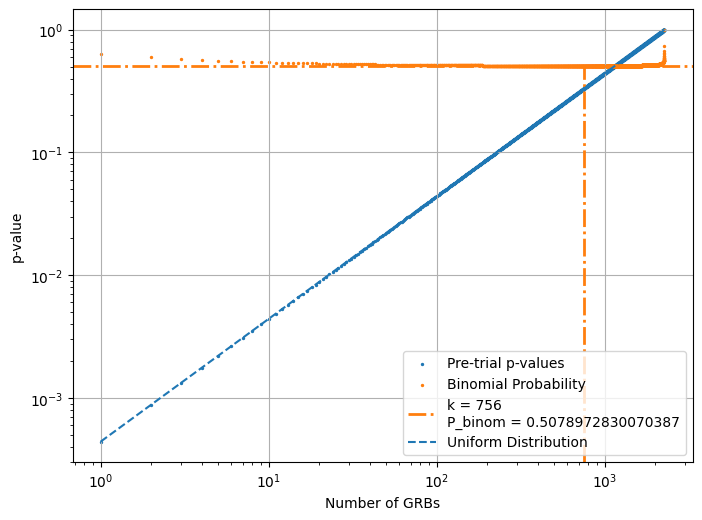

In [12]:
# Uniformly distributed Binomial Test
## example null hypothesis Binomial Test
# grb_tw_pre_post_p = pd.DataFrame(get_all_GRB_best_p_values(0)) # 0 is a random number bewteen 0-1,000,000
x = np.r_[1:2268+1]
binomial_result = binomial_test(x/2268.)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
# 2268 GRBs
x = np.r_[1:2268+1]
# p_values
ax.scatter(x, np.sort(x/2268.), label="Pre-trial p-values", s=2)
# Binomial Probability
ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
# best Binomial
ax.vlines(binomial_result[0], 0, binomial_result[1], 
           linestyle='-.', color=sns.color_palette()[1], linewidth=2)
ax.axhline(binomial_result[1], 0, 2268, 
           linestyle='-.', color=sns.color_palette()[1], linewidth=2,
           label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")

# uniform line
ax.plot(x, x/2268., "--", label="Uniform Distribution")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of GRBs")
ax.set_ylabel("p-value")
# ax.set_title(f"{ag.grb_name}")
ax.grid(True)
ax.legend()

In [13]:
def plot_null_binom_example(trial_no):
    ## example null hypothesis Binomial Test
    grb_tw_pre_post_p = pd.DataFrame(get_all_GRB_best_p_values(trial_no)) # trial_no is a random number bewteen 0-1,000,000
    binomial_result = binomial_test(grb_tw_pre_post_p['post_trial_p'])
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    ax.scatter(x, np.sort(grb_tw_pre_post_p['post_trial_p']), label="Pre-trial p-values", s=2)
    # Binomial Probability
    ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
    # best Binomial
    ax.vlines(binomial_result[0], 0, binomial_result[1], 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2)
    ax.axhline(binomial_result[1], 0, 2268, 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2,
               label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    return ax, binomial_result

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (2,
  0.9999999999999999,
  0.315185,
  array([   1,    2,    3, ..., 2266, 2267, 2268]),
  array([1., 1., 1., ..., 1., 1., 1.])))

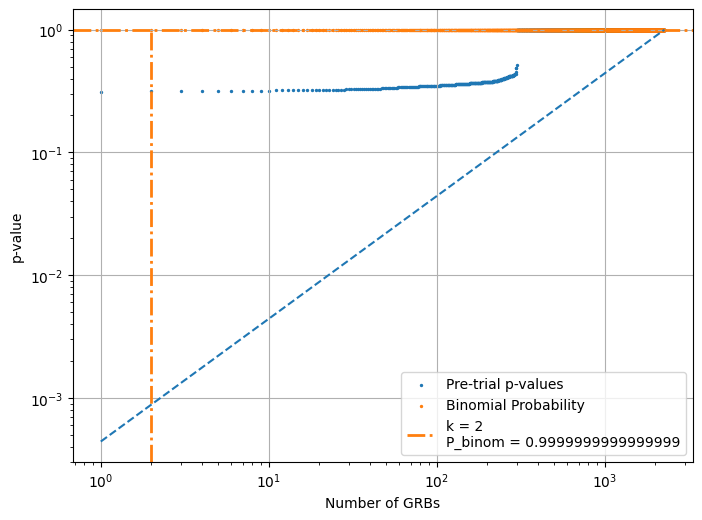

In [14]:
plot_null_binom_example(0)

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (1827,
  1.4367222464612875e-284,
  0.436596,
  array([   1,    2,    3, ..., 2266, 2267, 2268]),
  array([0.77830488, 0.45026525, 0.30439484, ..., 1.        , 1.        ,
         1.        ])))

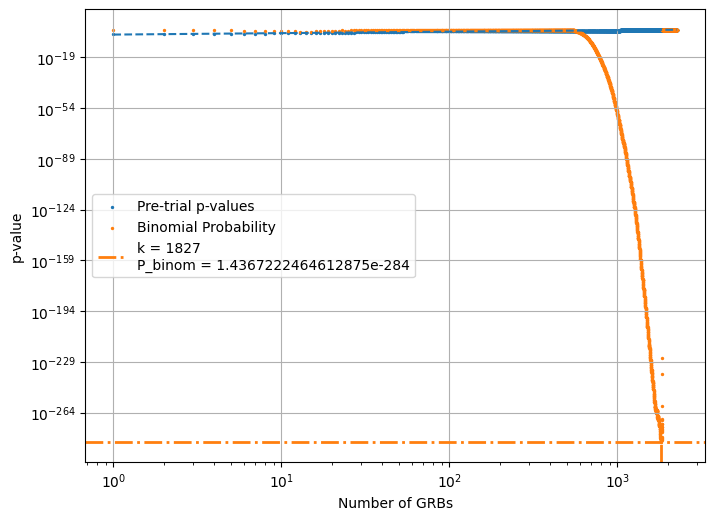

In [15]:
plot_null_binom_example(1)

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (2,
  0.9999999999999999,
  0.11456,
  array([   1,    2,    3, ..., 2266, 2267, 2268]),
  array([1., 1., 1., ..., 1., 1., 1.])))

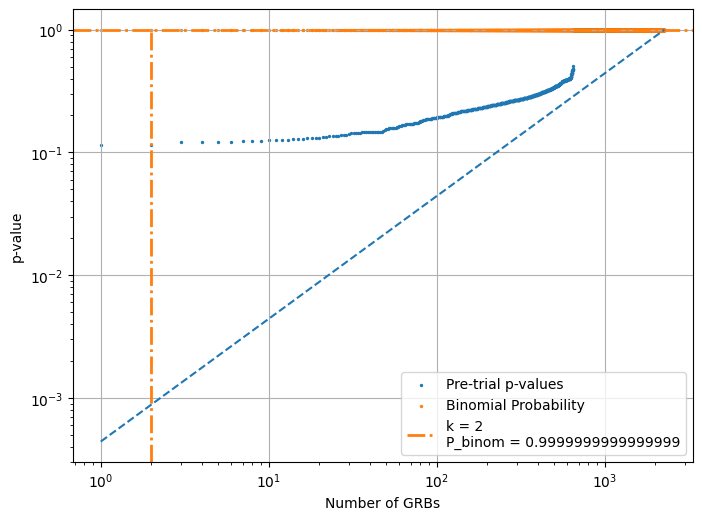

In [16]:
plot_null_binom_example(2)

In [17]:
def plot_pretrial_example(trial_no):
    ## example null hypothesis Binomial Test
    grb_tw_pre_post_p = pd.DataFrame(get_all_GRB_best_p_values(trial_no)) # trial_no is a random number bewteen 0-1,000,000
    binomial_result = binomial_test(grb_tw_pre_post_p['post_trial_p'])
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    ax.scatter(x, np.sort(grb_tw_pre_post_p['post_trial_p']), label="Pre-trial p-values", s=2)
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    return ax, binomial_result

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (1827,
  1.4367222464612875e-284,
  0.436596,
  array([   1,    2,    3, ..., 2266, 2267, 2268]),
  array([0.77830488, 0.45026525, 0.30439484, ..., 1.        , 1.        ,
         1.        ])))

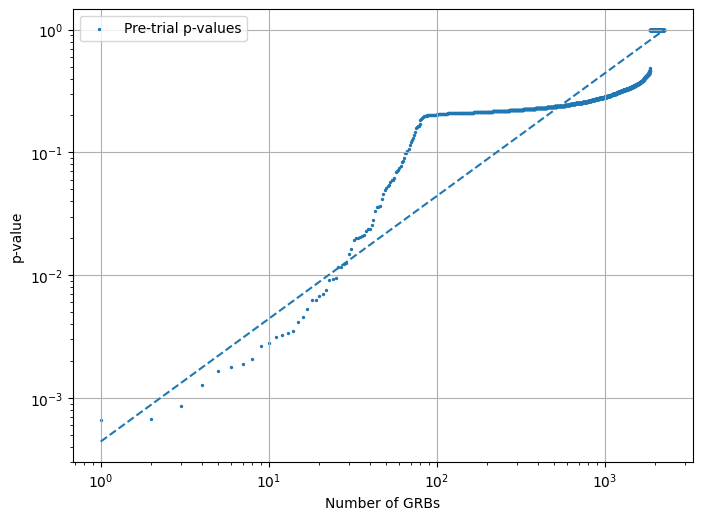

In [18]:
plot_pretrial_example(1)

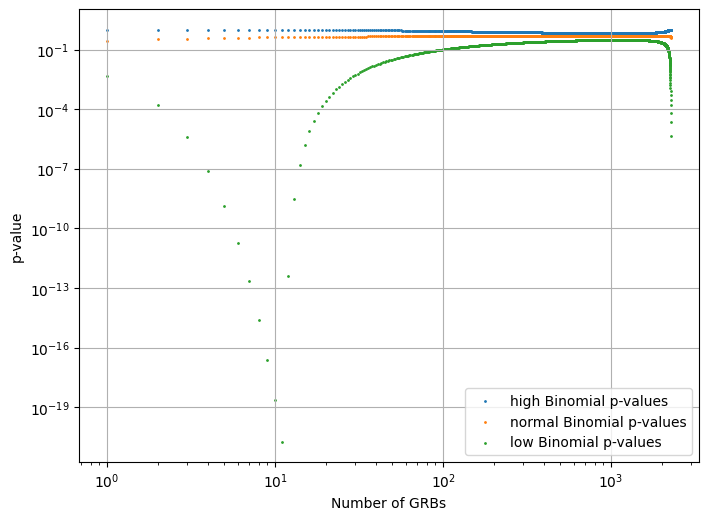

In [19]:
x = np.r_[0:2268]
a = [0.9, 1.0, 1.1]
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
for aa, la in zip(a[::-1], ['low','normal','high'][::-1]):
    # Test 1, ratio * rank / N
#     p = np.minimum(1.0, np.maximum(1/22680, aa*x/2268))
#     y = stats.binom.sf(x, 2268, p)
    ## 1.1 pre-trial p-values
#     ax.scatter(x, p, label=f"{la} pre-trial p-values", s=1)
     ## 1.2 Binomial p-values
#     ax.scatter(x, y, label=f"{la} Binomial p-values", s=1)
    
    # Test 2, rank / N +/- offset
    p = np.minimum(1.0, np.maximum(1/22680, x/2268 - 0.05*(1-aa)))
    y = stats.binom.sf(x, 2268, p)
    ## 2.1 pre-trial p-values
#     ax.scatter(x, p, label=f"{la} pre-trial p-values", s=1)
    ## 2.2 Binomial p-values
    ax.scatter(x, y, label=f"{la} Binomial p-values", s=1)
    
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of GRBs")
ax.set_ylabel("p-value") 
ax.grid(True)
ax.legend()

## 1.2 Multiple null Binomials

In [20]:
# median null hypothesis Binomial

def get_multiple_run_post_p(num_run, load=False):
    """
    Get num_run * 2268 p-values. 
    The post_p are p-values corrected with `effective_trial/pre_post`
    
    Parameters
    ----------
        num_run: int
            First a few runs (e.g. 1000)
        
    Returns
    -------
        multiple_run_post_p: array_like
            shape: num_run * 2268
    """
    multiple_run_post_p = []
    # get_all_GRB_best_p_values is using multiprocessing
    # so we cannot use multiprocessing here
    if load:
        return np.load(ANA_DIR+f"/binomial_test/null_binom/multiple_run_post_p_{num_run}.npy")
    
    for i in range(num_run):
        multiple_run_post_p.append(get_all_GRB_best_p_values(i)['post_trial_p'])
    multiple_run_post_p = np.array(multiple_run_post_p)
    return multiple_run_post_p


In [21]:
# # test
# with time("get multiple run post p"):
#     multiple_run_post_p = get_multiple_run_post_p(10)


In [22]:
def save_multiple_run_post_p(num_run):
    multiple_run_post_p = get_multiple_run_post_p(num_run)
    np.save(ANA_DIR+f"/binomial_test/null_binom/multiple_run_post_p_{num_run}.npy", 
            multiple_run_post_p)

In [23]:
# # test
# with time("save multiple run post p"):
#     save_multiple_run_post_p(10)

In [24]:
# # test
# get_multiple_run_post_p(10, load=True)

In [25]:
# ## example null hypothesis Binomial Test - Multiple Runs - 5000 Runs ### NOT A GOOD PLOT
# runs = 5000
# multiple_run_post_p = get_multiple_run_post_p(runs, load=True)
# multiple_run_post_p = np.sort(multiple_run_post_p, axis=1)

# p_values = np.median(multiple_run_post_p, axis=0)
# p_value_16 = np.quantile(multiple_run_post_p, 0.16, axis=0)
# p_value_84 = np.quantile(multiple_run_post_p, 0.84, axis=0)

# binomial_result = binomial_test(p_values)

# fig, ax = plt.subplots(figsize=(8,6), dpi=100)
# # 2268 GRBs
# x = np.r_[1:2268+1]
# # p_values
# ax.scatter(x, p_values, label="Median Pre-trial p-values", s=2)
# # p_values error
# ax.errorbar(x, p_values, yerr=[p_values-p_value_16, p_value_84-p_values], fmt='none',alpha=0.1)
# # Binomial Probability
# ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
# # best Binomial
# ax.vlines(binomial_result[0], 0, binomial_result[1], 
#            linestyle='-.', color=sns.color_palette()[1], linewidth=2)
# ax.axhline(binomial_result[1], 0, 2268, 
#            linestyle='-.', color=sns.color_palette()[1], linewidth=2,
#            label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
# # uniform line
# ax.plot(x, x/2268., "--")

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Number of GRBs")
# ax.set_ylabel("p-value")
# ax.set_title(f"Binomial p-values of {runs} Trials")
# ax.grid(True)
# ax.legend()

## 1.3 CDF of pre-trial p-values for all GRBs (not pre-trial binomial)

In [26]:
## example null hypothesis Binomial Test - Multiple Runs - 5000 Runs
runs = 5000
multiple_run_post_p = get_multiple_run_post_p(runs, load=True)

In [27]:
all_pre_p = np.ravel(multiple_run_post_p)

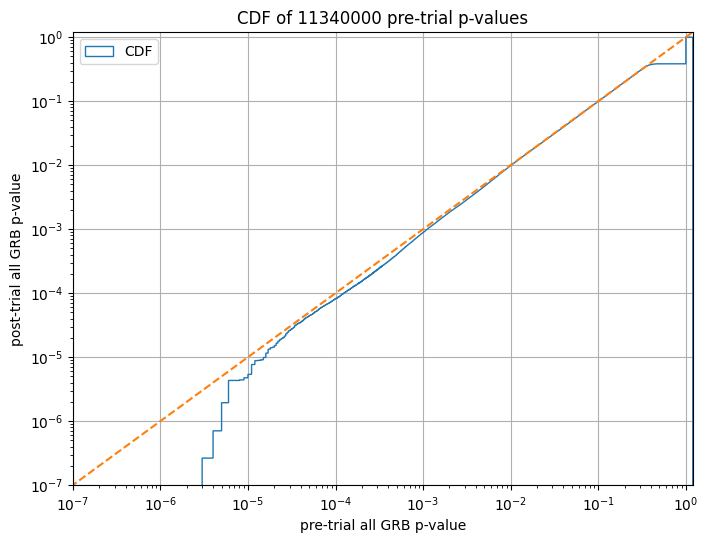

In [28]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_pre_p, 
        bins=np.r_[np.unique(all_pre_p),1.2], 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1e-6, 1.2)
ax.set_ylim(0.1e-6, 1.2)
ax.set_xlabel("pre-trial all GRB p-value")
ax.set_ylabel("post-trial all GRB p-value")
ax.set_title(f"CDF of {all_pre_p.size} pre-trial p-values")
ax.grid(True)
ax.legend()

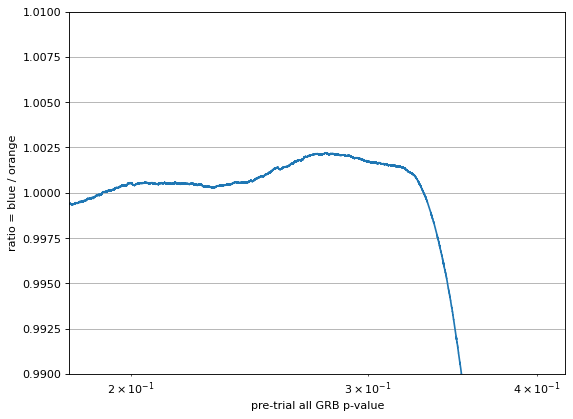

In [29]:
## the blue CDF curves are actually not always below the orange reference line
fig, ax = plt.subplots(figsize=(8,6), dpi=80)
ax.plot(bins[1:], n / bins[1:])
ax.set_ylim(0.99, 1.01)
ax.set_xlim(0.18, 0.42)
ax.set_xscale("log")
ax.set_xlabel("pre-trial all GRB p-value")
ax.set_ylabel("ratio = blue / orange")
ax.grid(True)

## 1.4 CDF of all un-randomized Binomial p-values

In [30]:
multiple_null_binomial_results = np.array([binomial_test(single_run_post_p, epsilon=None) for single_run_post_p in multiple_run_post_p])
multiple_null_binomial_results[:2]


/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


array([[2, 0.9999999999999999, 0.315185,
        array([   1,    2,    3, ..., 2266, 2267, 2268]),
        array([1., 1., 1., ..., 1., 1., 1.])],
       [1827, 1.4367222464612875e-284, 0.436596,
        array([   1,    2,    3, ..., 2266, 2267, 2268]),
        array([0.77830488, 0.45026525, 0.30439484, ..., 1.        , 1.        ,
               1.        ])                                                    ]],
      dtype=object)

In [31]:
# for i, re in enumerate(multiple_null_binomial_results):
#     if re[0] == 1: # best k is 1
#         print(i)
#         print(re)
#         plot_null_binom_example(i)
#         break
 

In [32]:
# for i, re in enumerate(multiple_null_binomial_results):
#     if re[1] == 0: # best binomial p-value is 0
#         print(i)
#         print(re)
#         plot_null_binom_example(i)  
#         break  

In [33]:
# for i, re in enumerate(multiple_null_binomial_results):
#     if re[2] < 1e-3: # p_k < 1e-3
#         print(i)
#         print(re)
#         plot_null_binom_example(i)  
#         break  

In [34]:
all_binomial_k = np.ravel([x[0] for x in multiple_null_binomial_results])
all_binomial_p = np.ravel([x[4] for x in multiple_null_binomial_results])

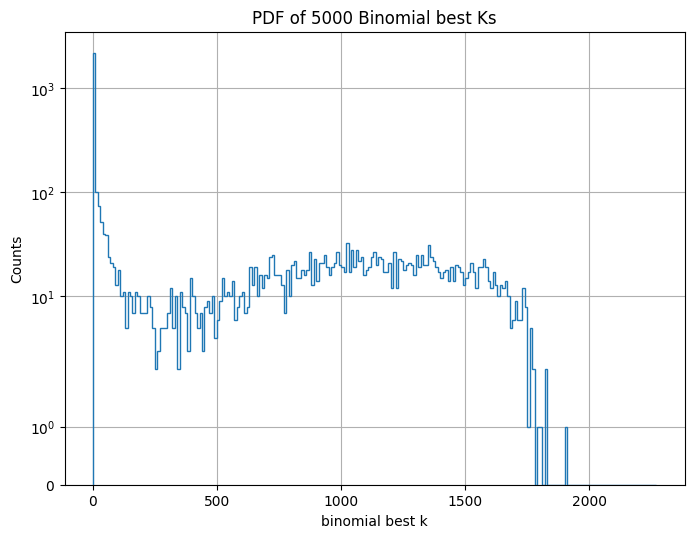

In [35]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_binomial_k, 
        bins=np.r_[0:2268+10:10], 
        density=False, 
        cumulative=False, 
#         label=f'PDF',
        histtype='step')

# ax.set_xscale("log")
ax.set_yscale("symlog")
# ax.set_xlim(0.8e-6, 1.2)
# ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("binomial best k")
ax.set_ylabel("Counts")
ax.set_title(f"PDF of {all_binomial_k.size} Binomial best Ks")
ax.grid(True)
# ax.legend()

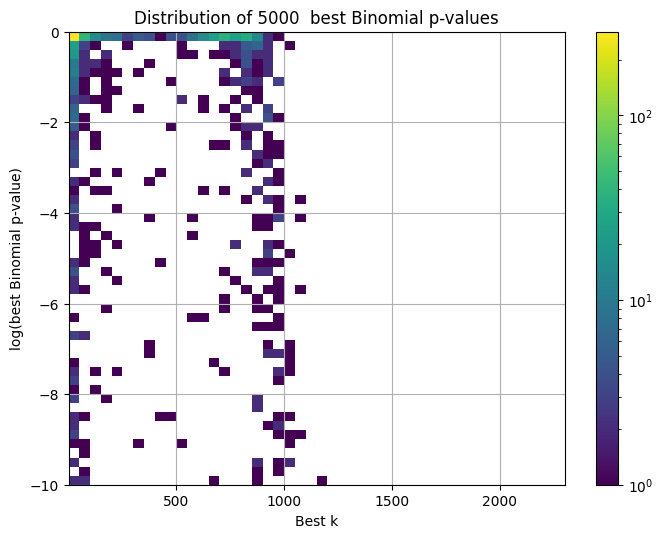

In [36]:
all_best_binomial_p_log = np.log10(np.maximum(1e-300, np.ravel([x[1] for x in multiple_null_binomial_results])))
all_best_binomial_p_log
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
h,xedges, yedges, image=ax.hist2d(all_binomial_k,  all_best_binomial_p_log,
        bins=[np.r_[1:2268+50:50], np.r_[-10:0+0.2:0.2]],norm=mpl.colors.LogNorm())

# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlim(0.8e-5, 1.2)
# ax.set_ylim(0.8e-4, 1.2)
ax.set_xlabel("Best k")
ax.set_ylabel("log(best Binomial p-value)")
ax.set_title(f"Distribution of {all_best_binomial_p_log.size}  best Binomial p-values")
ax.grid(True)
fig.colorbar(image, ax=ax)
# ax.legend()

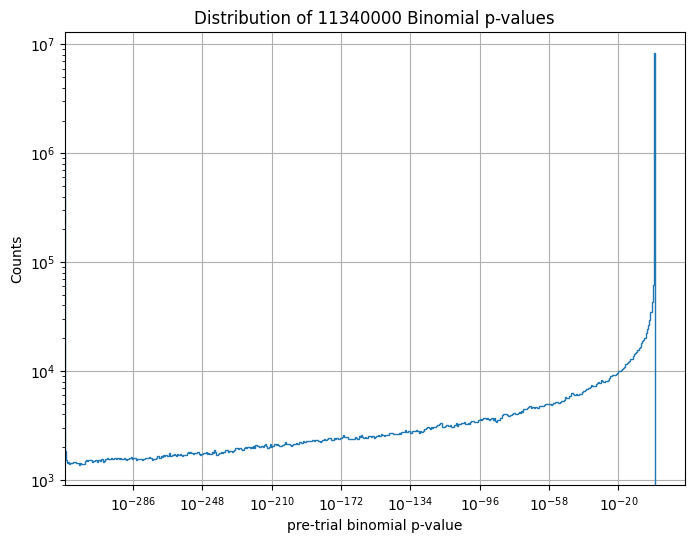

In [37]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_binomial_p, 
        bins=np.logspace(-324, np.log10(1.2), 500), 
        density=False, 
        cumulative=False, 
#         label=f'',
        histtype='step')

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0.8e-5, 1.2)
# ax.set_ylim(0.8e-4, 1.2)
ax.set_xlabel("pre-trial binomial p-value")
ax.set_ylabel("Counts")
ax.set_title(f"Distribution of {all_binomial_p.size} Binomial p-values")
ax.grid(True)
# ax.legend()

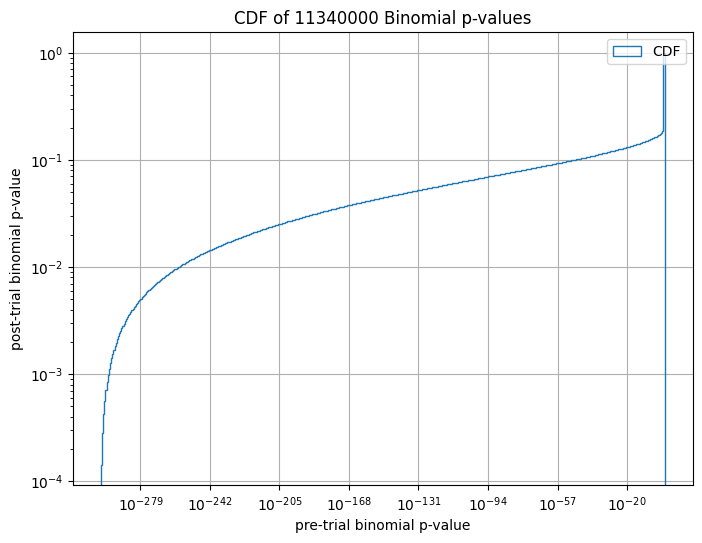

In [38]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_binomial_p, 
        bins=np.logspace(-300, 0, 500), 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x, "--")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0.8e-6, 1.2)
# ax.set_ylim(0.8e-4, 1.2)
ax.set_xlabel("pre-trial binomial p-value")
ax.set_ylabel("post-trial binomial p-value")
ax.set_title(f"CDF of {all_binomial_p.size} Binomial p-values")
ax.grid(True)
ax.legend()

In [39]:
stats.binom.ppf(q=1-1e-2, n=2268, p=1e-4)

2.0

## 1.5 Randomized pre-trial p-values and resulting Binomial p-values

In [40]:
multiple_run_post_p

array([[1.      , 1.      , 1.      , ..., 1.      , 1.      , 0.368583],
       [0.34213 , 0.213731, 0.241519, ..., 0.332722, 0.238338, 0.362664],
       [0.234571, 1.      , 1.      , ..., 1.      , 1.      , 0.344706],
       ...,
       [0.02598 , 1.      , 0.04756 , ..., 0.005397, 0.113932, 0.234187],
       [1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      ],
       [1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      ]],
      dtype=float32)

In [41]:
rng = np.random.default_rng(0)
multiple_run_post_p_permuted = rng.permuted(multiple_run_post_p, axis=0)

In [42]:
multiple_permuted_null_binomial_results = np.array([binomial_test(single_run_post_p, epsilon=None) for single_run_post_p in multiple_run_post_p_permuted])
multiple_permuted_null_binomial_results[:3]


/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


array([[92, 0.0443731892997317, 0.033764,
        array([   1,    2,    3, ..., 2266, 2267, 2268]),
        array([0.74768931, 0.8334066 , 0.86623917, ..., 1.        , 1.        ,
               1.        ])                                                    ],
       [10, 0.011756834529793432, 0.00187,
        array([   1,    2,    3, ..., 2266, 2267, 2268]),
        array([0.50274463, 0.16319964, 0.16356859, ..., 1.        , 1.        ,
               1.        ])                                                    ],
       [779, 0.022014702097472746, 0.323397,
        array([   1,    2,    3, ..., 2266, 2267, 2268]),
        array([0.6108087 , 0.7399881 , 0.54590209, ..., 1.        , 1.        ,
               1.        ])                                                    ]],
      dtype=object)

In [43]:
all_premuted_binomial_k = np.ravel([x[0] for x in multiple_permuted_null_binomial_results])
all_premuted_binomial_p = np.ravel([x[4] for x in multiple_permuted_null_binomial_results])


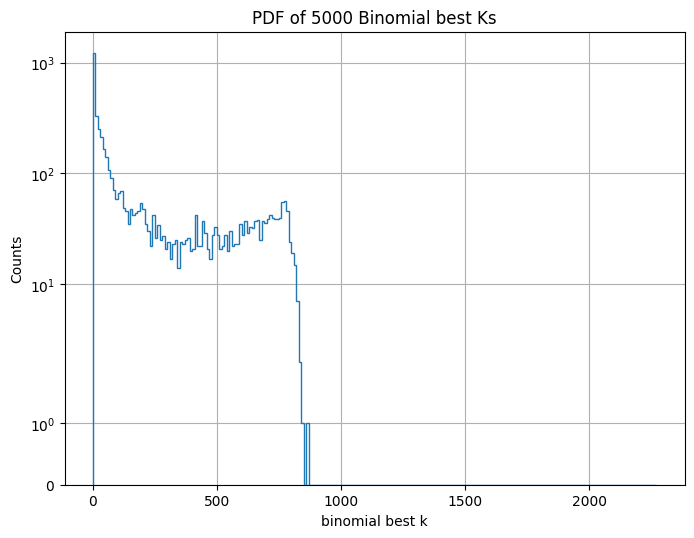

In [44]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_premuted_binomial_k, 
        bins=np.r_[0:2268+10:10], 
        density=False, 
        cumulative=False, 
#         label=f'PDF',
        histtype='step')

# ax.set_xscale("log")
ax.set_yscale("symlog")
# ax.set_xlim(0.8e-6, 1.2)
# ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("binomial best k")
ax.set_ylabel("Counts")
ax.set_title(f"PDF of {all_binomial_k.size} Binomial best Ks")
ax.grid(True)
# ax.legend()

/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


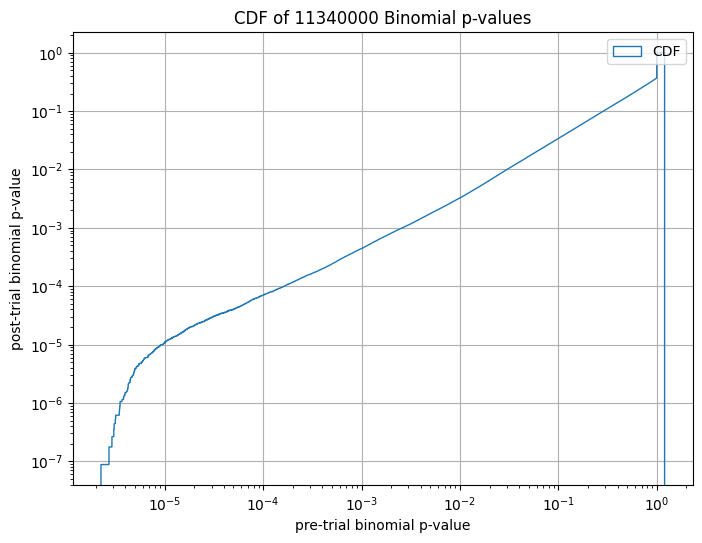

In [47]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_premuted_binomial_p, 
                       bins=np.r_[np.unique(all_premuted_binomial_p), 1.2],
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x, "--")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0.8e-6, 1.2)
# ax.set_ylim(0.8e-4, 1.2)
ax.set_xlabel("pre-trial binomial p-value")
ax.set_ylabel("post-trial binomial p-value")
ax.set_title(f"CDF of {all_premuted_binomial_p.size} Binomial p-values")
ax.grid(True)
ax.legend()

# 2. Signal-hypothesis Binomial Test

In [29]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
multiple_run_post_p = get_multiple_run_post_p(10, load=True)
p_values = np.median(np.sort(multiple_run_post_p, axis=1), axis=0)


In [30]:
def get_replaced_p_values(p_values, num_to_replace=1, replaced_p=stats.norm.sf(3), seed=0):
    """
    Get num_run * 2268 p-values. 
    The post_p are p-values corrected with `effective_trial/pre_post`
    
    Parameters
    ----------
        p_values: array_like
            shape: 2268
            
        num_to_replace: int
            we change num_to_replace out of 2268 p-values
            
        replaced_p: float
            e.g. 3-sigma p-value=stats.norm.sf(3)
            
        seed: int
            randomizer seed
        
    Returns
    -------
        new_p_values: array_like
            shape: 2268
    """
    random = np.random.RandomState(seed)
    indices = np.sort(random.choice(len(p_values), num_to_replace))
    new_p_values = np.copy(p_values)
    new_p_values[indices] = replaced_p
    return new_p_values
    

In [31]:
def plot_simulated_binom_example(p_values):
    """
    p_values here are assumed corrected already
    """
    ## example null hypothesis Binomial Test
    binomial_result = binomial_test(p_values)

    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    ax.scatter(x, np.sort(p_values), label="Pre-trial p-values", s=2)
    # Binomial Probability
    ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
    # best Binomial
    ax.vlines(binomial_result[0], 0, binomial_result[1], 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2)
    ax.axhline(binomial_result[1], 0, 2268, 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2,
               label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    return ax

Text(0.5, 1.0, '0 p-values are replaced with 2-sigma p')

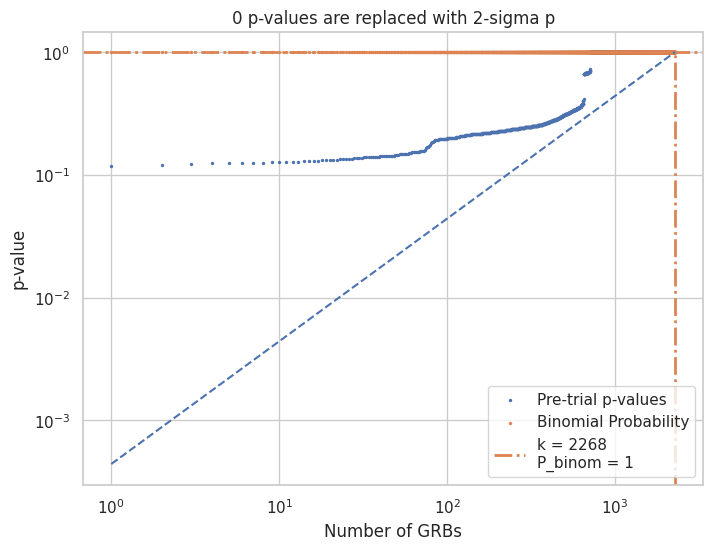

In [32]:
num_to_replace=0
sigma=2
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

In [35]:
num_to_replace=1
sigma=2
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

NameError: name 'plot_simulated_binom_example' is not defined

Text(0.5, 1.0, '1 p-values are replaced with 3-sigma p')

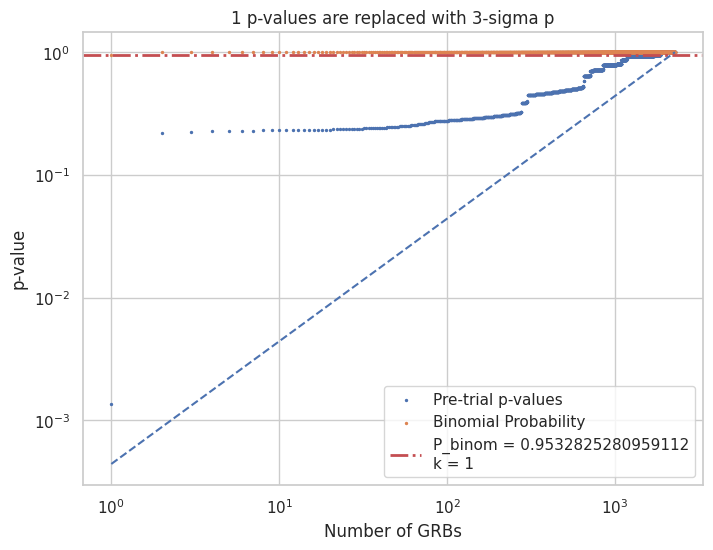

In [88]:
num_to_replace=1
sigma=3
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

Text(0.5, 1.0, '2 p-values are replaced with 2-sigma p')

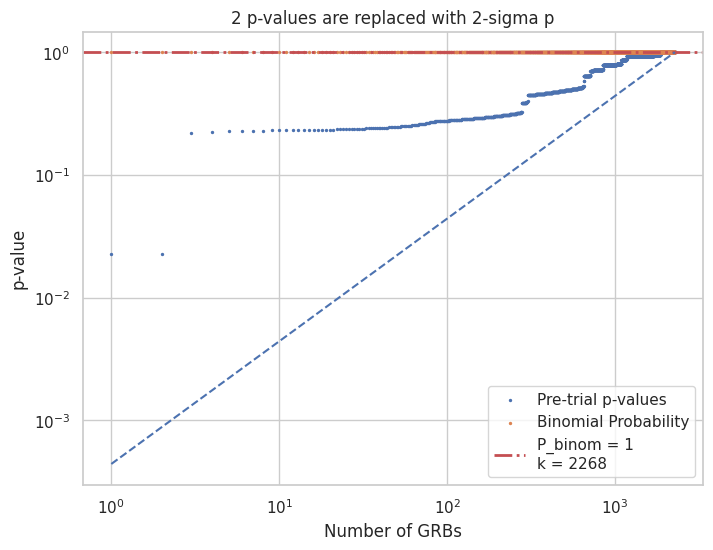

In [93]:
num_to_replace=2
sigma=2
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

Text(0.5, 1.0, '2 p-values are replaced with 3-sigma p')

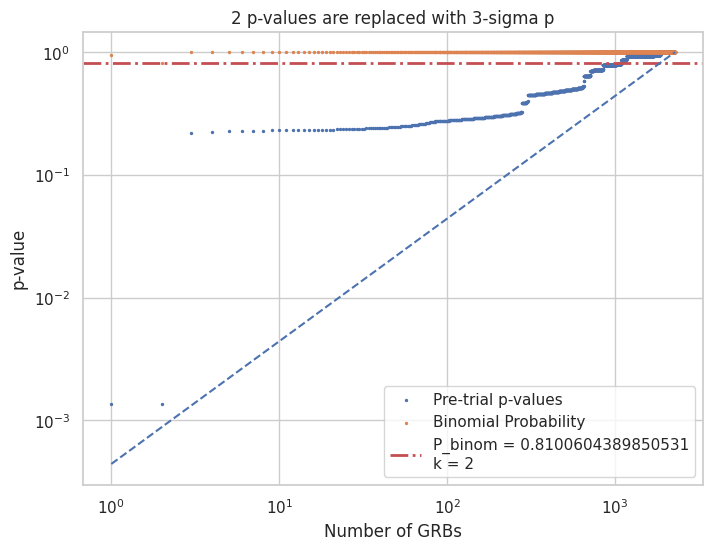

In [94]:
num_to_replace=2
sigma=3
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

Text(0.5, 1.0, '5 p-values are replaced with 2-sigma p')

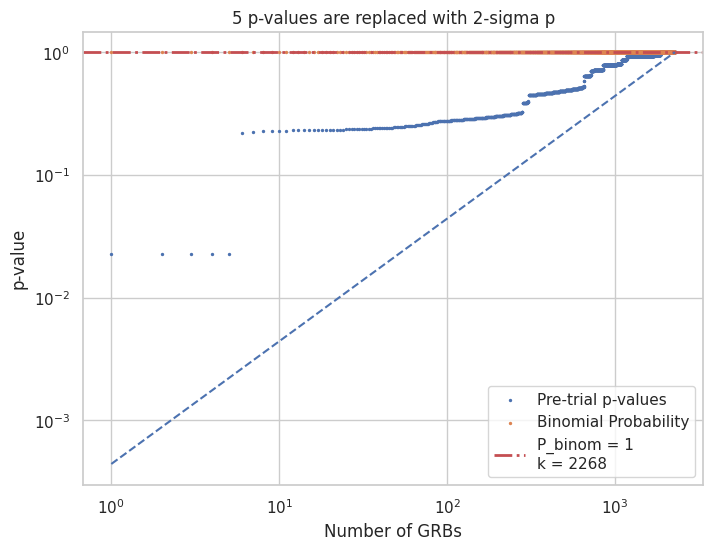

In [95]:
num_to_replace=5
sigma=2
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

Text(0.5, 1.0, '5 p-values are replaced with 3-sigma p')

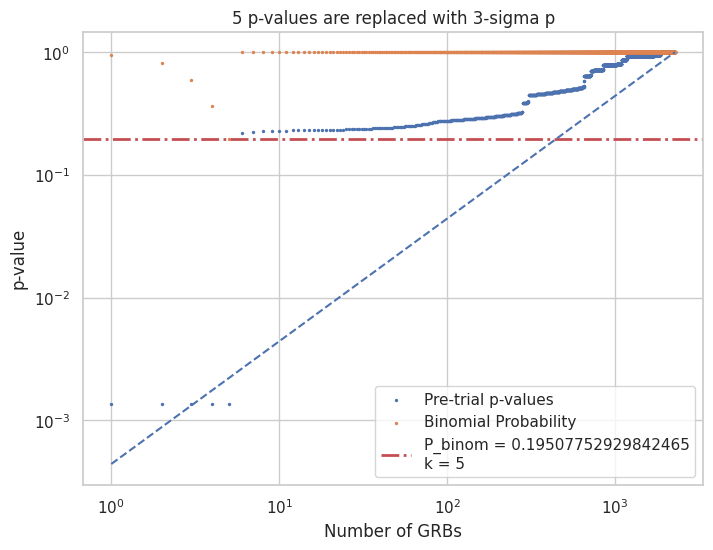

In [96]:
num_to_replace=5
sigma=3
replaced_p=stats.norm.sf(sigma)

ax = plot_simulated_binom_example(
    get_replaced_p_values(
        p_values, 
        num_to_replace=num_to_replace,
        replaced_p=replaced_p, 
        seed=0
    )
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")